In [1]:
from typing import List

import numpy as np
import pandas as pd
from lightkurve import LightCurve
from matplotlib import pyplot as plt

from exo_finder.default_datasets import sunlike_lightcurves_ds, exo_dataset, candidate_dataset
from exo_finder.visualization.lightcurve_plotting import plot_lightcurve_ax

from paths import LC_STATS_RESULT_FILE

In [2]:
exo_db = exo_dataset.load_known_exoplanets_dataset()
toi_db = candidate_dataset.load_candidate_exoplanets_dataset()
lc_db = sunlike_lightcurves_ds.load_lightcurve_dataset()
exoplanets_ids = set(exo_db.unique_tic_ids) | set(toi_db.unique_tic_ids)

In [12]:
# Load datasets
combined_analysis = pd.read_feather(LC_STATS_RESULT_FILE)

# exclude invalid lightcurves
combined_analysis = combined_analysis.loc[(combined_analysis['normalized_std'] > 0) & (combined_analysis['split_count'] > 0)]

# exclude lightcurves with known planets
combined_analysis = combined_analysis[~np.isin(combined_analysis['tic_id'], list(exoplanets_ids))]
combined_analysis

tic_id     obs_id  length  gap_ratio  split_ratio  split_count  \
0       94339635  191165600   15268   0.110800     0.999738            4   
1      232634196  233655124   10764   0.405241     0.760870            2   
2      219775505  233653342   13063   0.280023     0.626962            2   
3       38600576  173749314   16552   0.106296     0.494804            2   
4       38600576  151520342   17078   0.144871     0.719347            3   
...          ...        ...     ...        ...          ...          ...   
10154  349762699  151536688   16417   0.113603     0.498873            2   
10155  349762699  238539262   14176   0.168625     0.577737            2   
10156  198238028   27430268   16259   0.093186     0.983209            4   
10157  141766144  238531615   13212   0.202399     0.619891            2   
10158  220428876  252313236   20257   0.022469     0.808609            4   

              mad  normalized_std         min_f         max_f      median_f  
0       21.402344        0.000579  55697.410156  55970.855469  55834.085938  
1      569.283203        0.060659  14061.884766  18347.923828  17495.183594  
2        6.575195        0.002165   4470.972168   4540.862305   4505.213867  
3       22.042969        0.000491  68130.328125  68433.656250  68268.593750  
4       26.285156        0.000578  68506.859375  68858.445312  68680.671875  
...           ...             ...           ...           ...           ...  
10154    5.205078        0.003303   2347.297607   2414.472412   2385.514893  
10155    5.339966        0.003392   2301.563965   2361.751221   2332.704590  
10156   21.032227        0.002375  13374.957031  13645.866211  13507.748047  
10157    7.385742        0.001633   6636.606934   6727.302246   6680.746582  
10158    9.938477        0.001102  13313.053711  13441.088867  13376.326172  

[10028 rows x 11 columns]

In [4]:
COLUMNS_OF_INTEREST = ["median_f", "min_f", "max_f", "length", 'gap_ratio', 'normalized_std', "mad"]
combined_analysis[COLUMNS_OF_INTEREST].describe()

median_f         min_f         max_f        length     gap_ratio  \
count  1.015900e+04  1.015900e+04  1.015900e+04  10159.000000  10159.000000   
mean   5.529039e+04  5.495133e+04  5.556727e+04  15722.204646      0.152781   
std    1.538844e+05  1.534575e+05  1.543604e+05   2625.115953      0.118810   
min    1.141845e+03 -1.930976e+04  1.165940e+03   4481.000000      0.022469   
25%    7.077478e+03  6.945068e+03  7.162309e+03  13927.500000      0.052747   
50%    1.670259e+04  1.653466e+04  1.683865e+04  15544.000000      0.131103   
75%    4.557165e+04  4.519370e+04  4.609412e+04  17991.000000      0.207353   
max    3.436409e+06  3.408983e+06  3.466070e+06  20257.000000      0.778022   

       normalized_std           mad  
count    10159.000000  10159.000000  
mean         0.003931     69.585045  
std          0.015927    575.657715  
min          0.000107      3.954407  
25%          0.000708      8.671875  
50%          0.001272     13.529785  
75%          0.002289     26.061523  
max          0.320848  35157.593750

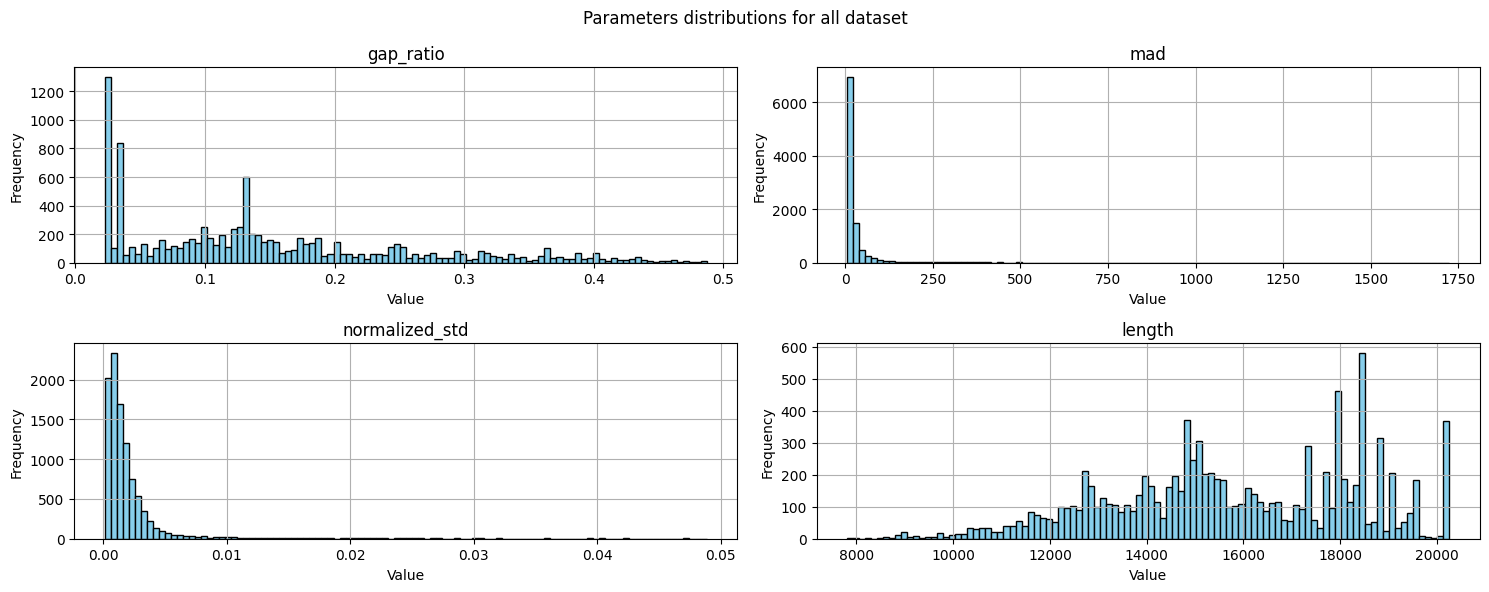

In [5]:
def plot_histograms(df: pd.DataFrame, title: str, columns: list[str] = COLUMNS_OF_INTEREST):  
    c = 2
    # Calculate the number of rows and columns for subplots
    num_cols = len(columns)
    num_rows = (num_cols + c-1) // c
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, c, figsize=(15, num_rows*3))
    
    # Flatten axs if necessary
    if num_rows > 1:
        axs = axs.flatten()
    
    # Plot histograms for each column
    for i, col in enumerate(columns):
        # Remove outliers 3-sigma away from the mean
        median = np.median(df[col])
        std = df[col].std()
        filtered_data = df[(df[col] >= median - 3 * std) & (df[col] <= median + 3 * std)]
        
        ax = axs[i]
        ax.hist(filtered_data[col], bins=100, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    # Adjust layout
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_histograms(combined_analysis, title="Parameters distributions for all dataset", columns=["gap_ratio", "mad", "normalized_std", "length"])

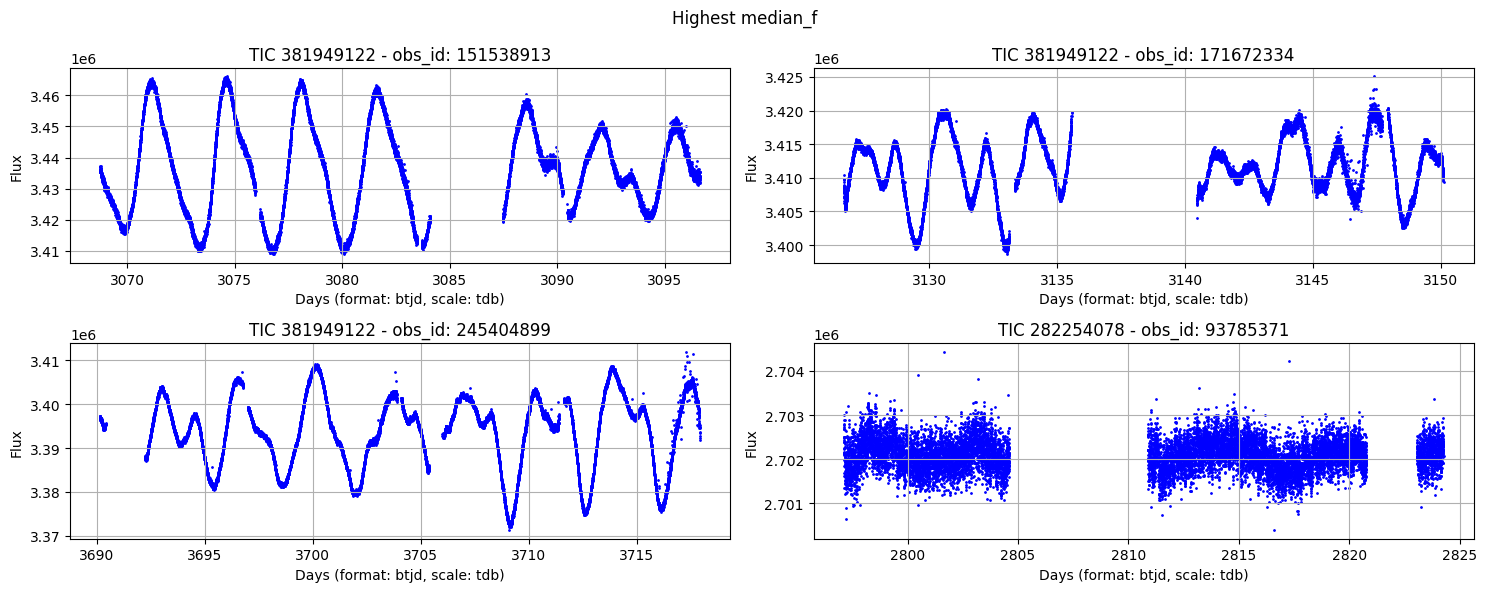

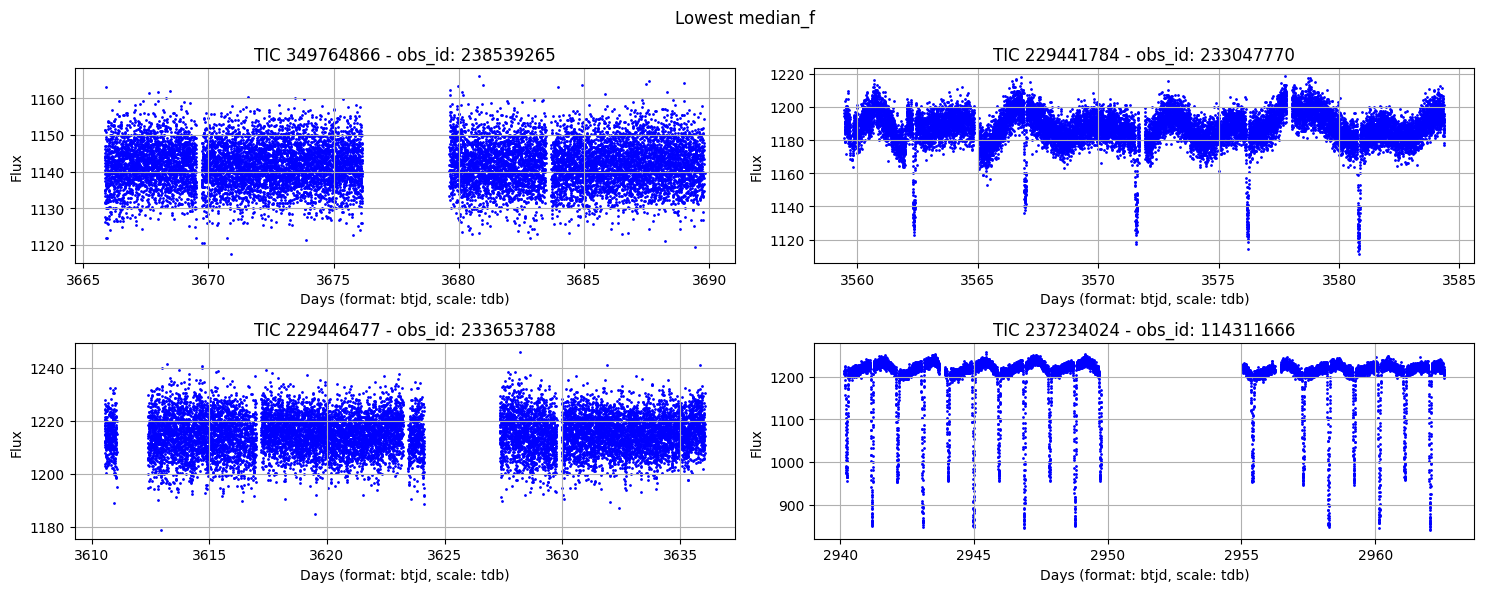

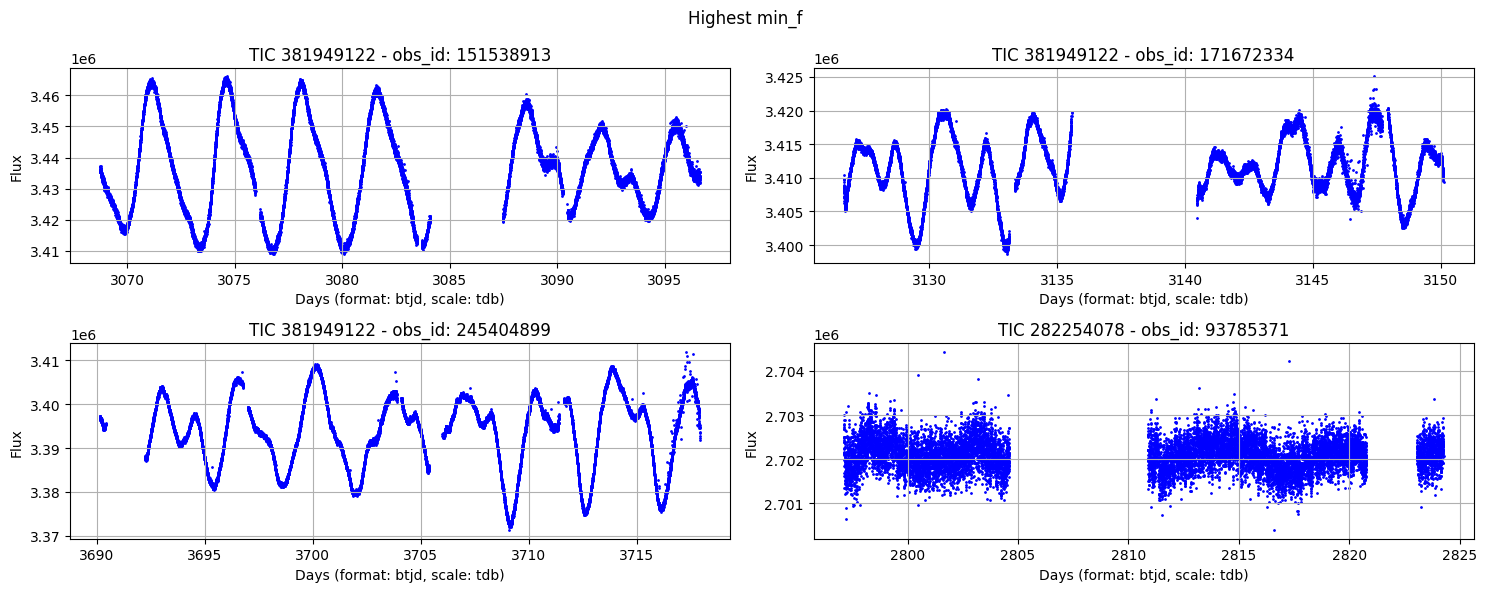

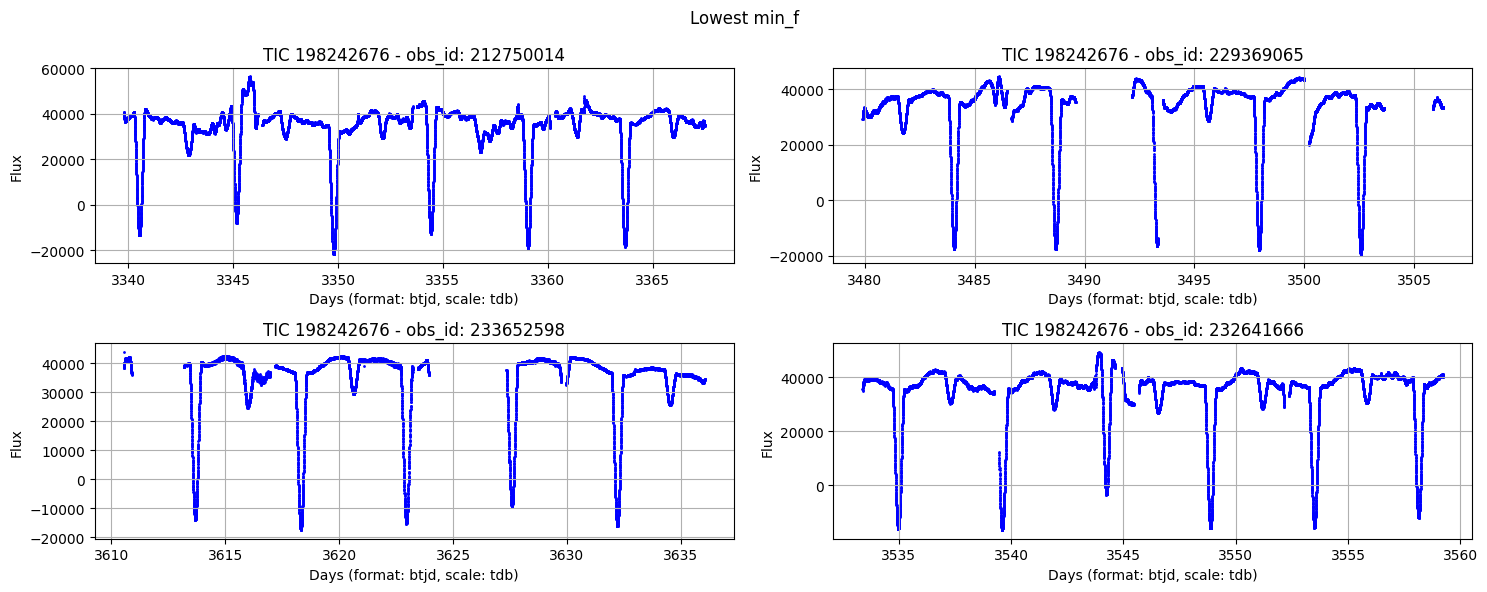

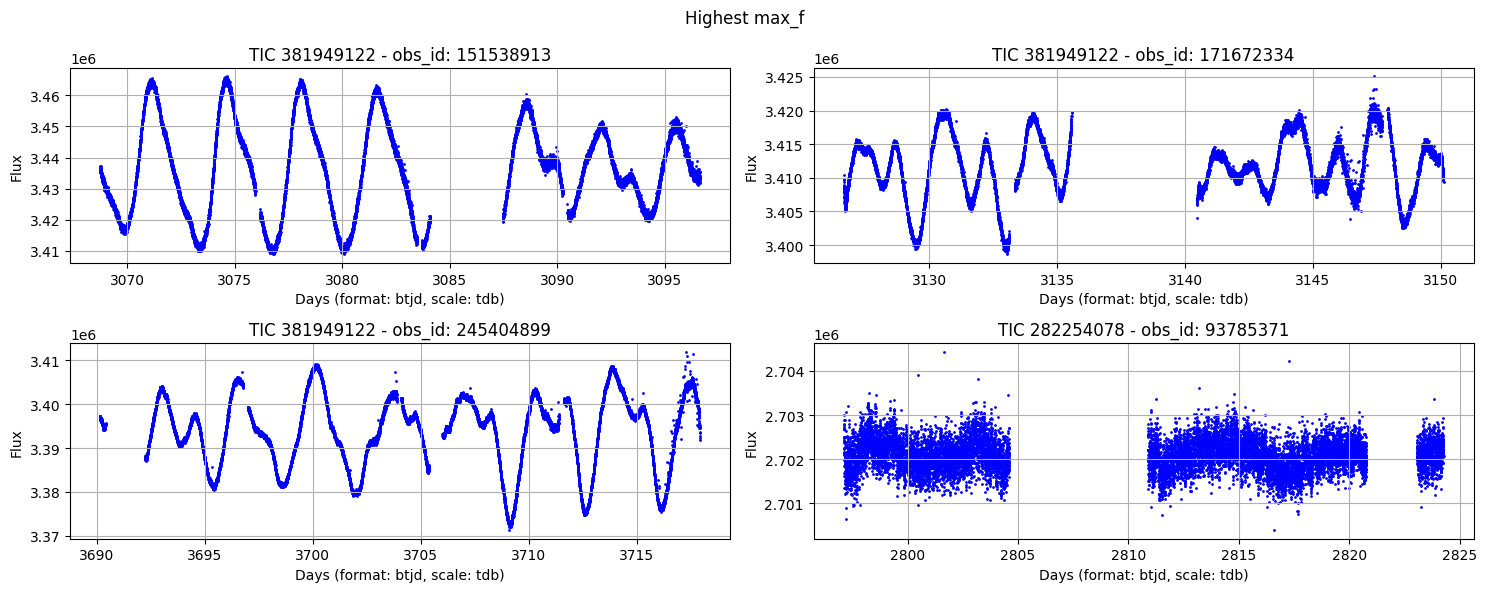

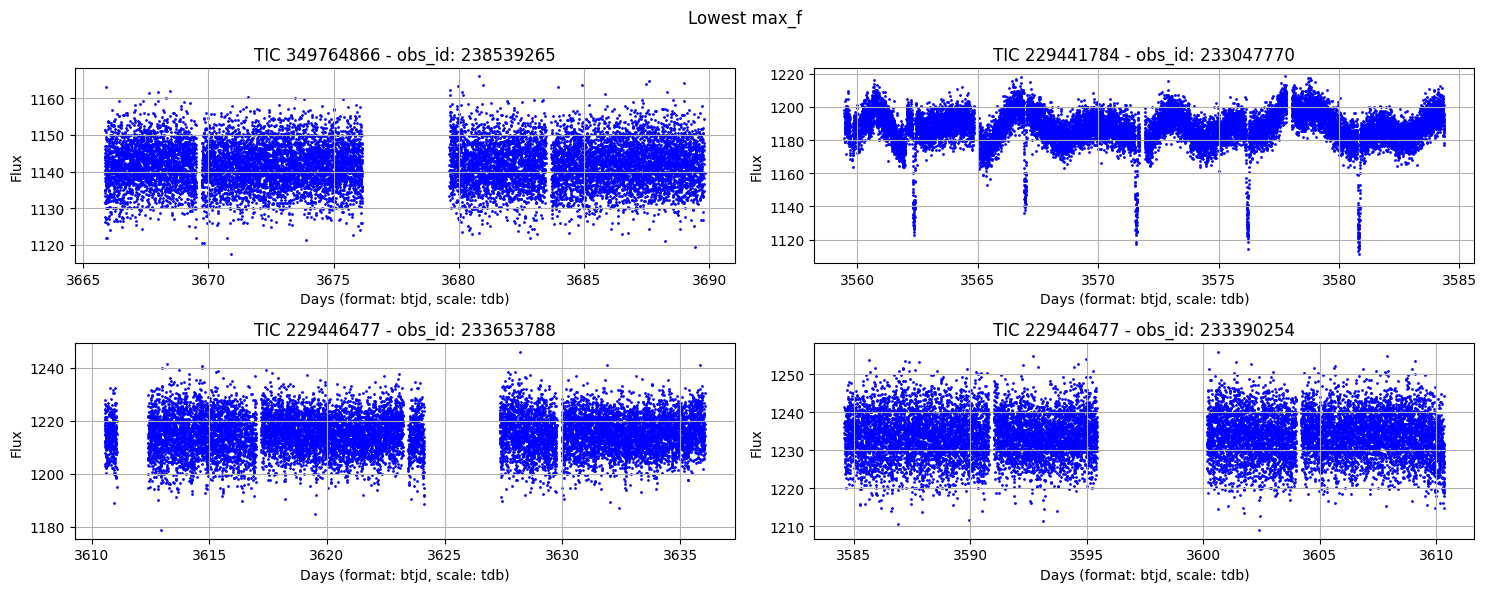

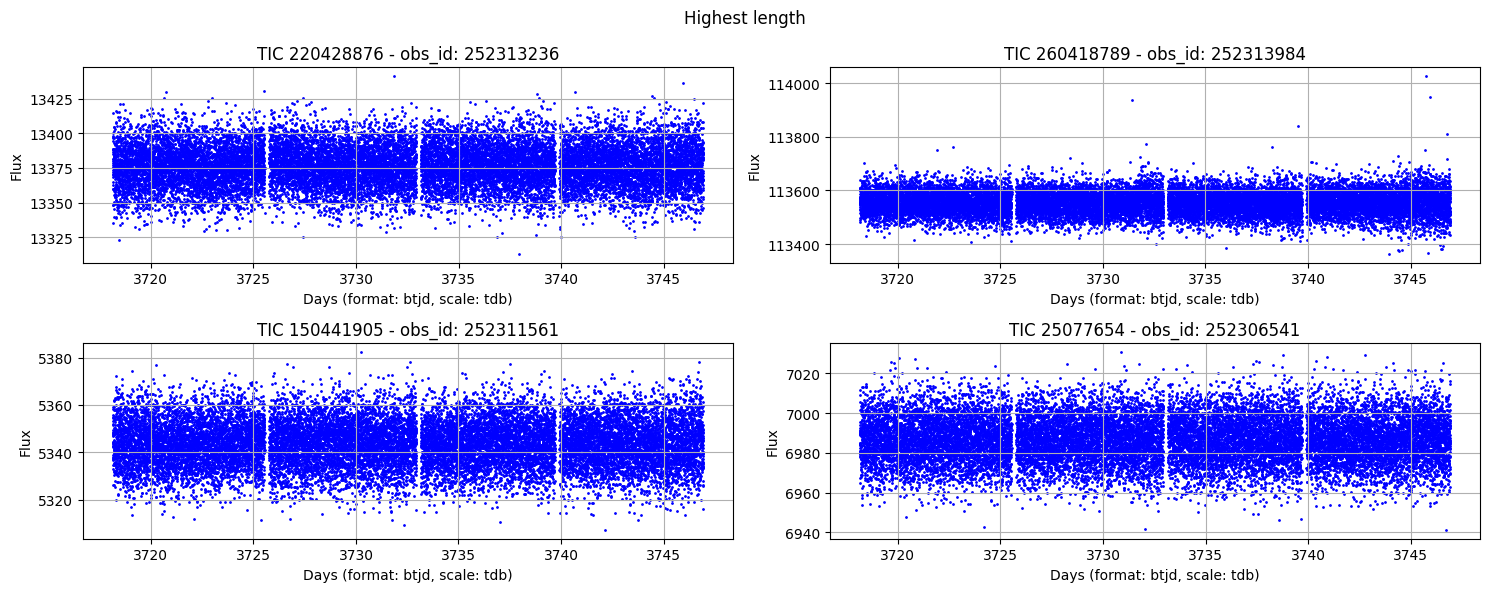

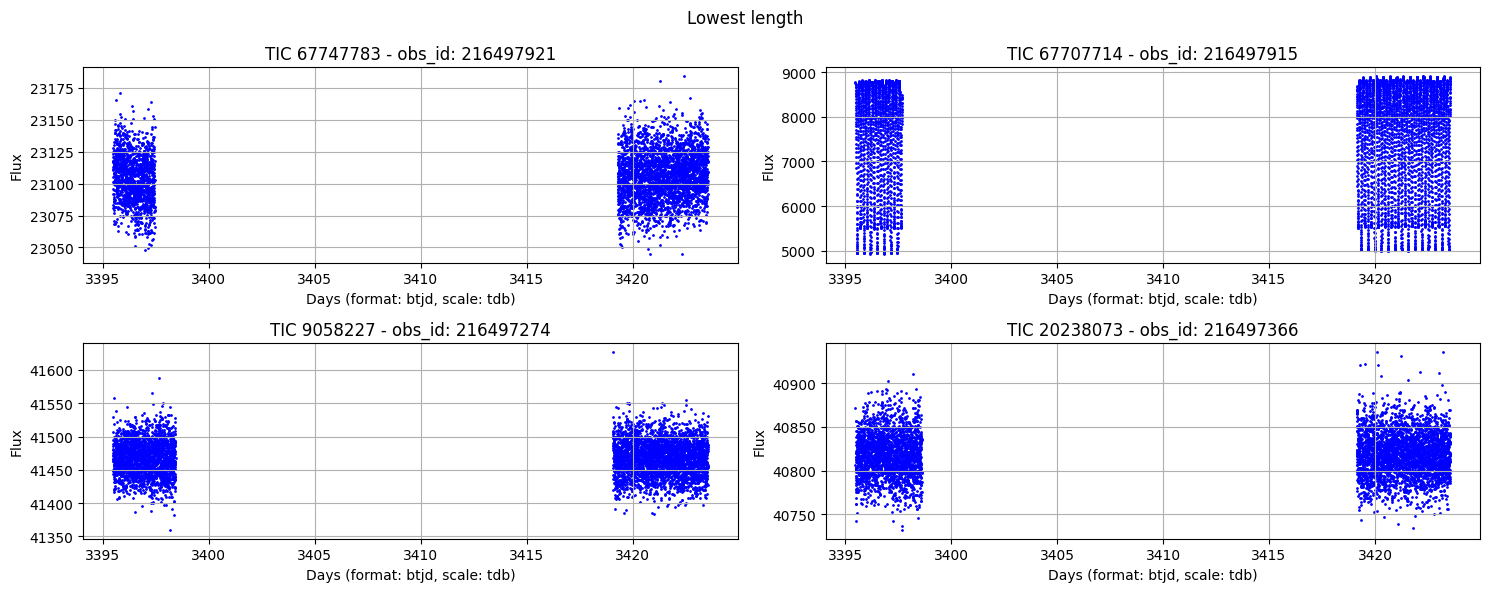

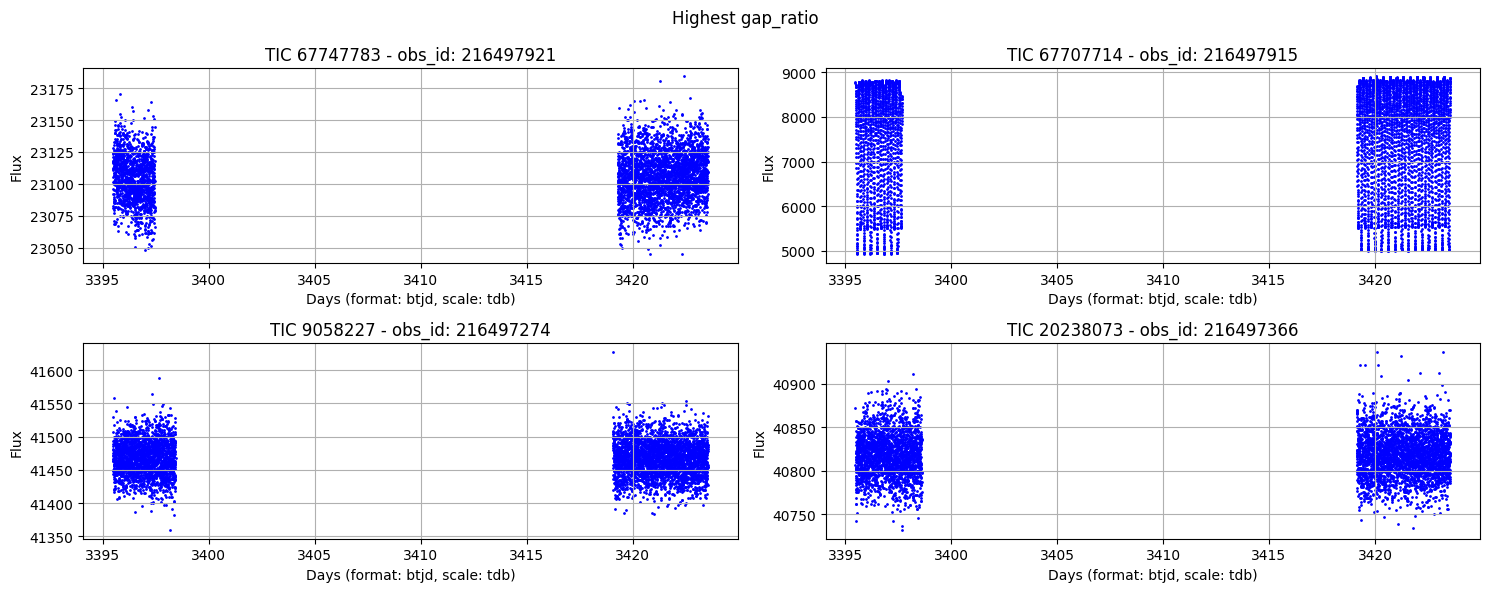

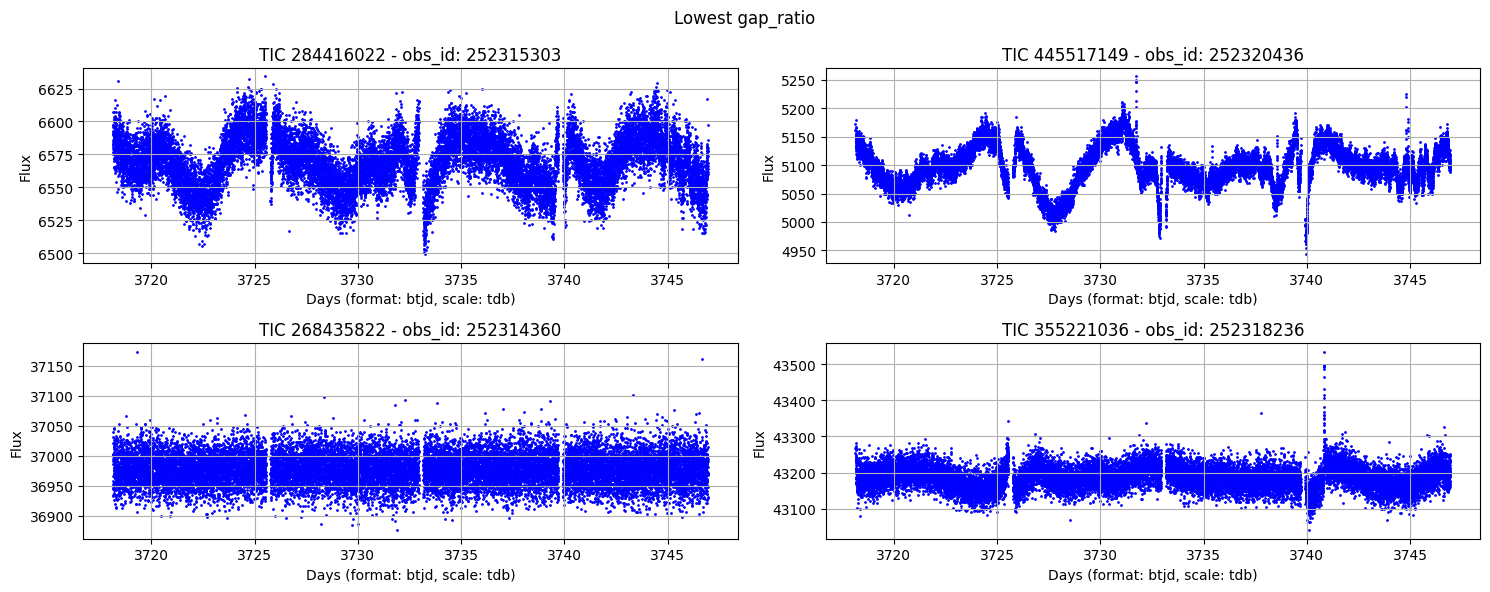

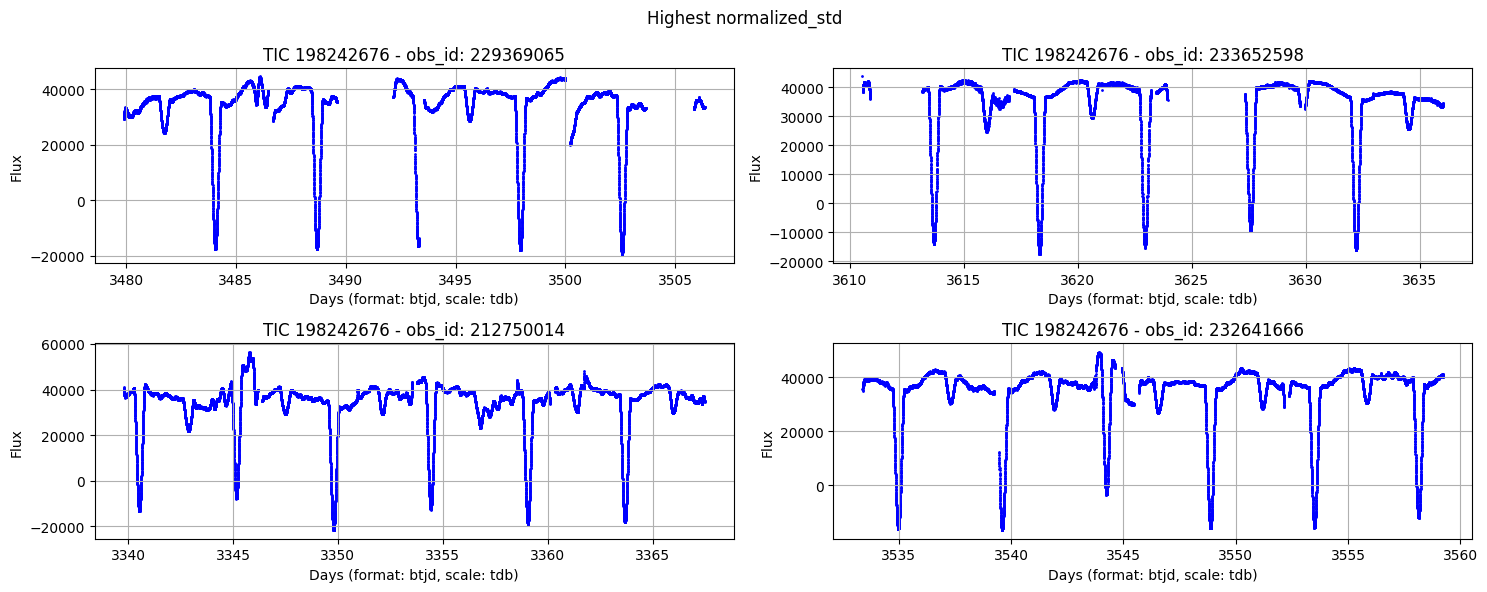

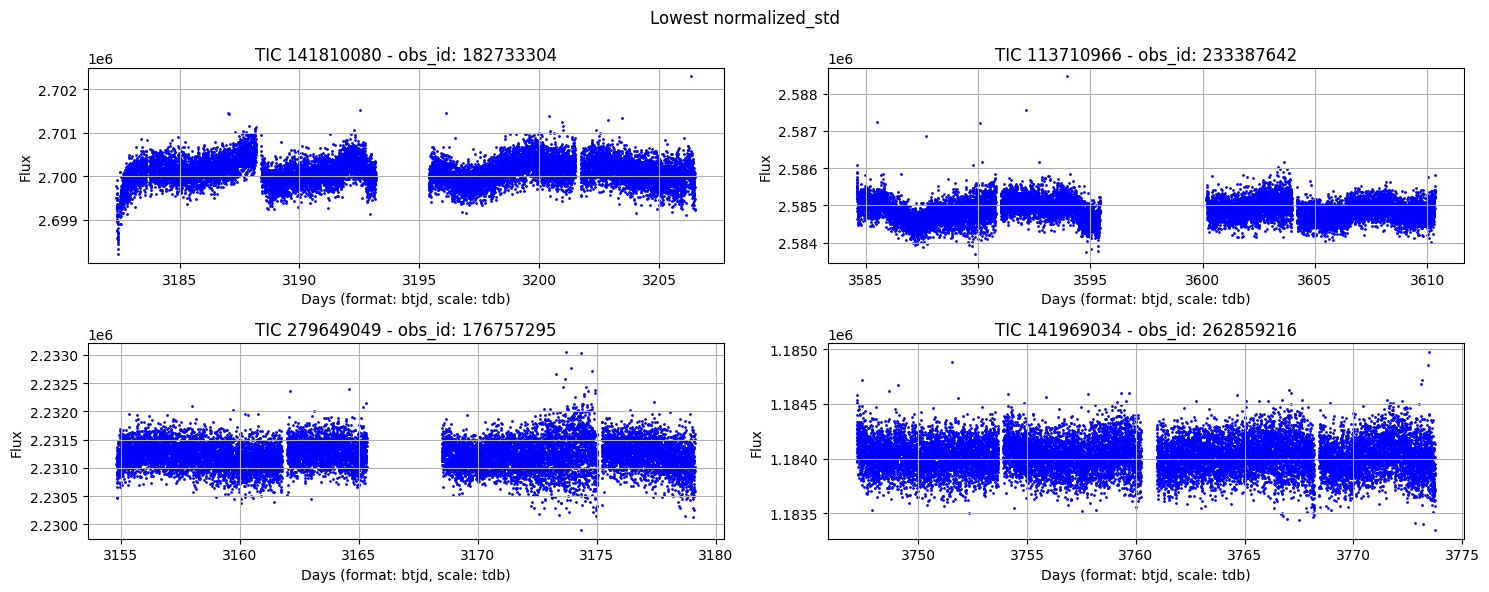

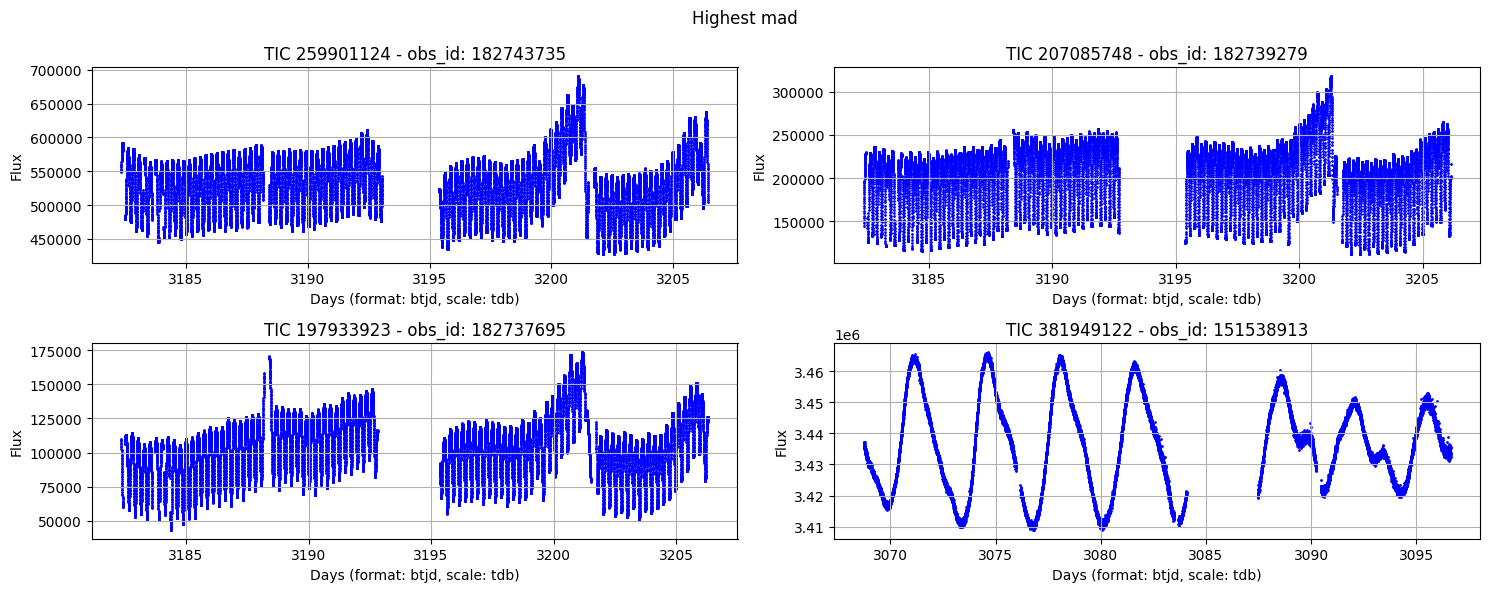

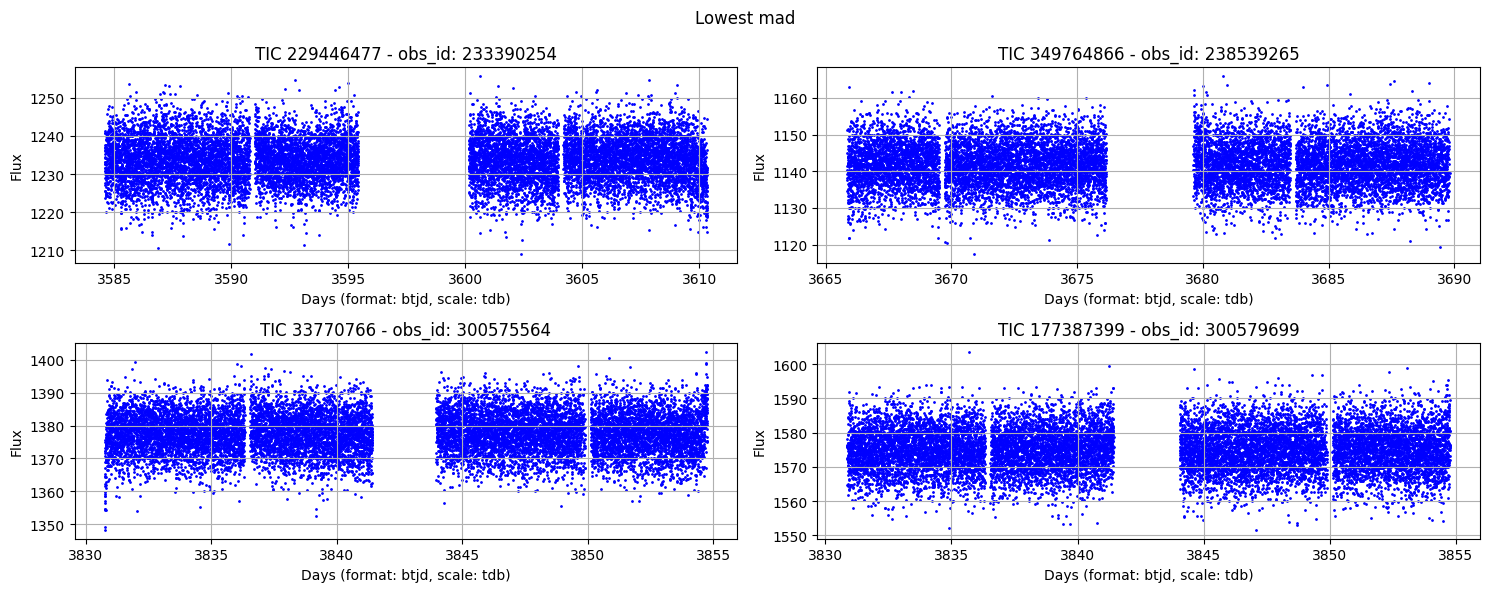

In [6]:
def plot_observations(lcs: List[LightCurve], obs_ids: pd.Series, title: str):
    c = 2
    r = (len(lcs) + 1) // c
    
    fig, axes = plt.subplots(r, c, figsize=(15, 3*r))
    axes = axes.flatten()
    
    for lc, obsid, ax in zip(lcs, obs_ids, axes):
        plot_lightcurve_ax(lc, ax, title=lc.meta["OBJECT"]+f" - obs_id: {obsid}")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_observations(df: pd.DataFrame) -> List[LightCurve]:
    lcs = []
    for _, row in df.iterrows():
        lcs.append(lc_db.load_by_obs_id(row.obs_id))
    return lcs

def show_high_and_low_parametrer(df: pd.DataFrame, parameter: str):
    high_val = df.sort_values(parameter, ascending=False).head(4)
    low_val = df.sort_values(parameter, ascending=True).head(4)
    
    high_lc = get_observations(high_val)
    low_lc = get_observations(low_val)
    
    plot_observations(high_lc, high_val.obs_id, title=f"Highest {parameter}")
    plot_observations(low_lc, low_val.obs_id, title=f"Lowest {parameter}")

for col in COLUMNS_OF_INTEREST:
    show_high_and_low_parametrer(combined_analysis, col)

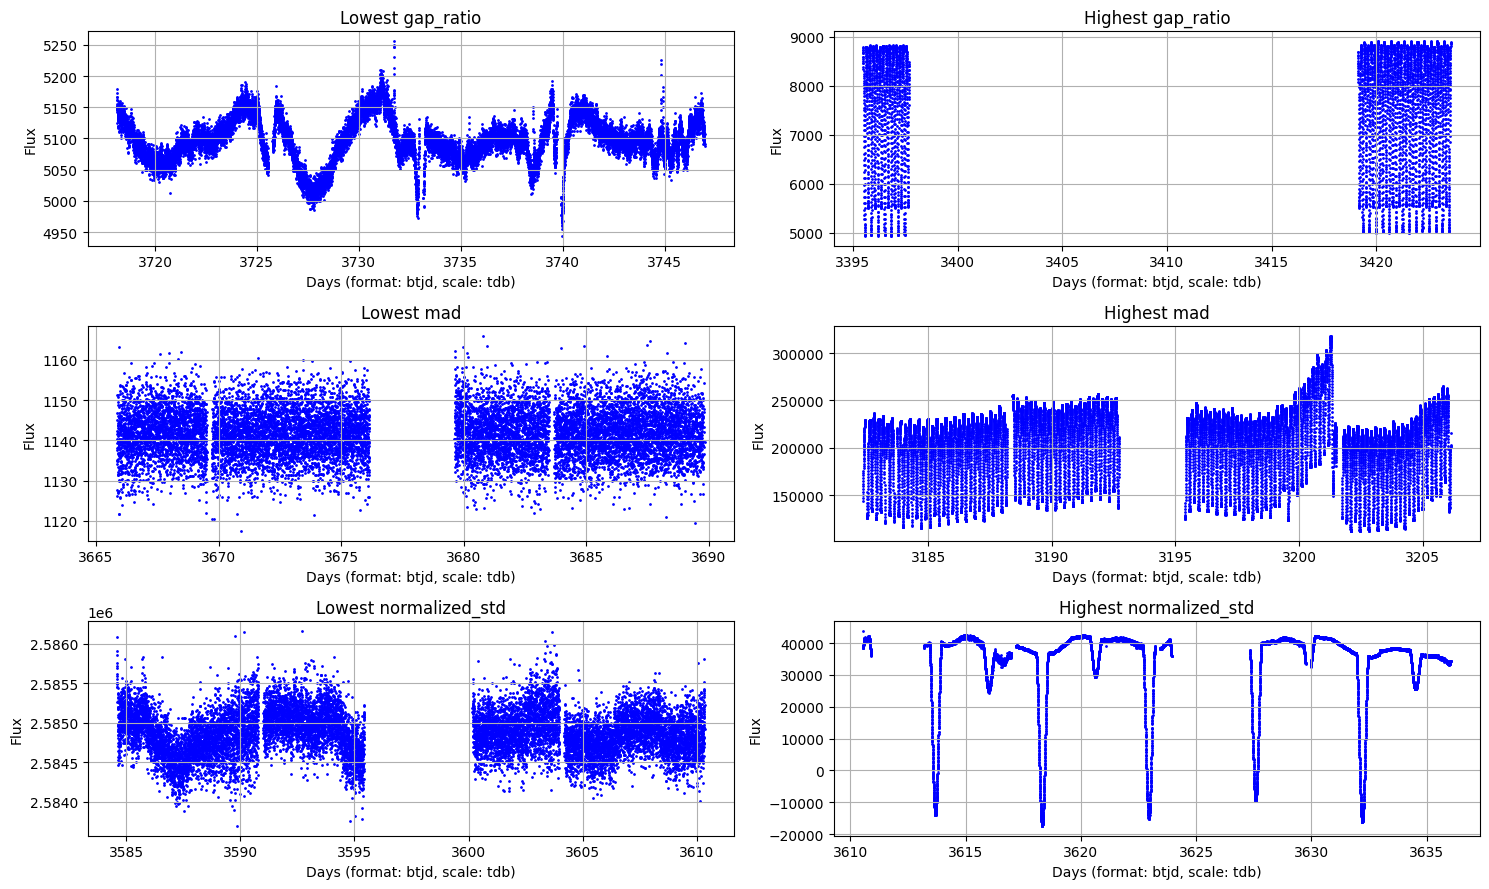

In [7]:
def plot_min_max(parameters: list[str], df: pd.DataFrame):
    rows = len(parameters)
    fig, axes = plt.subplots(rows, 2, figsize=(15, rows*3))
    for i, parameter in enumerate(parameters):
        ax1, ax2 = axes[i]
        sorted_df = df.sort_values(parameter, ascending=True)
        low_val = sorted_df.iloc[1]
        high_val = sorted_df.iloc[-2]
            
        low_lc = lc_db.load_by_obs_id(low_val.obs_id).remove_outliers()
        high_lc = lc_db.load_by_obs_id(high_val.obs_id).remove_outliers()
        
        plot_lightcurve_ax(low_lc, ax1, title=f"Lowest {parameter}")
        plot_lightcurve_ax(high_lc, ax2, title=f"Highest {parameter}")
    plt.tight_layout()
    plt.show()
plot_min_max(parameters=["gap_ratio", "mad", "normalized_std"], df=combined_analysis)


# Defines Rules for dataset selection
## Gap Ratio should be small, limit MAD and STD

In [8]:
for r in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]:
    print(f"Number of gap_ratio less than {r}: {(combined_analysis.gap_ratio <= r).sum()}")

Number of gap_ratio less than 0.05: 2458
Number of gap_ratio less than 0.1: 3851
Number of gap_ratio less than 0.15: 6252
Number of gap_ratio less than 0.2: 7430
Number of gap_ratio less than 0.3: 8823
Number of gap_ratio less than 0.4: 9714


Number of lightcurves: 3159
Number of individual stars: 2693


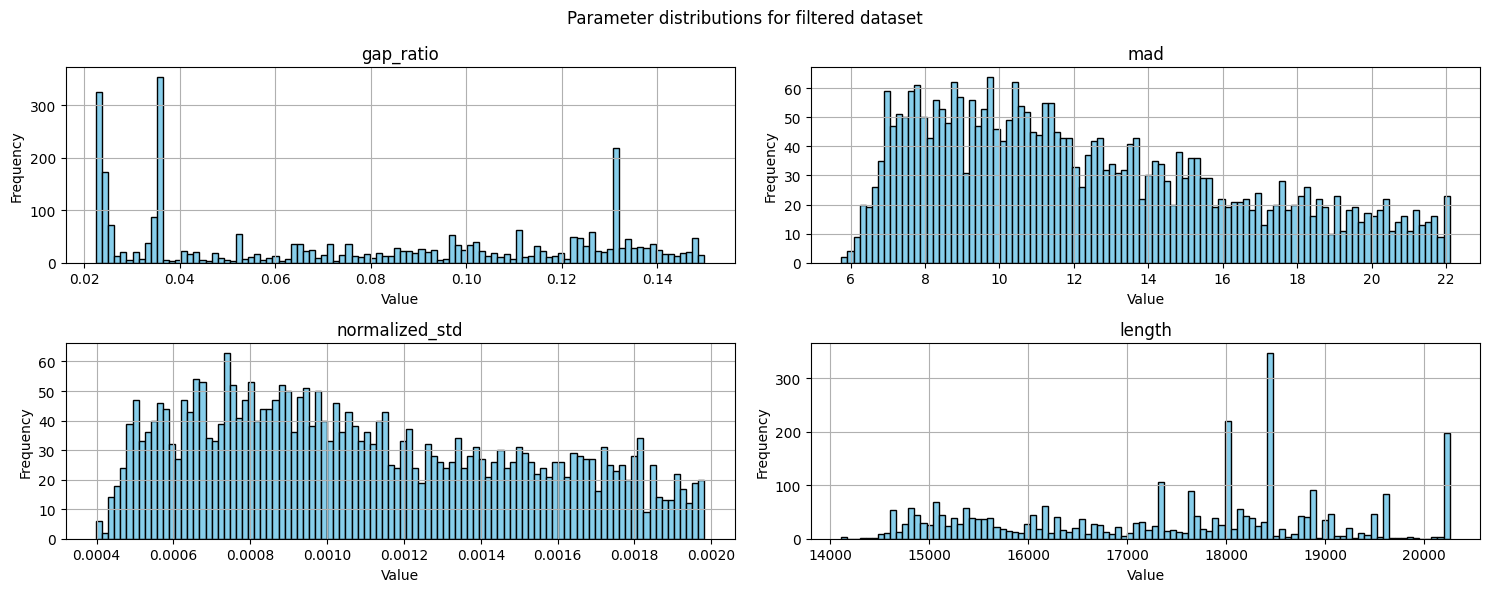

In [9]:
gap_ratio_threshold = 0.15
mad_threshold = np.percentile(combined_analysis["mad"], 70)
std_threshold = np.percentile(combined_analysis["normalized_std"], 70)

subset = combined_analysis[
    (combined_analysis.gap_ratio <= gap_ratio_threshold) &
    (combined_analysis.mad <= mad_threshold) &
    (combined_analysis.normalized_std <= std_threshold)
]

print("Number of lightcurves:", len(subset))
print("Number of individual stars:", len(subset["tic_id"].unique()))
plot_histograms(subset, title=f"Parameter distributions for filtered dataset", columns=["gap_ratio", "mad", "normalized_std", "length"])

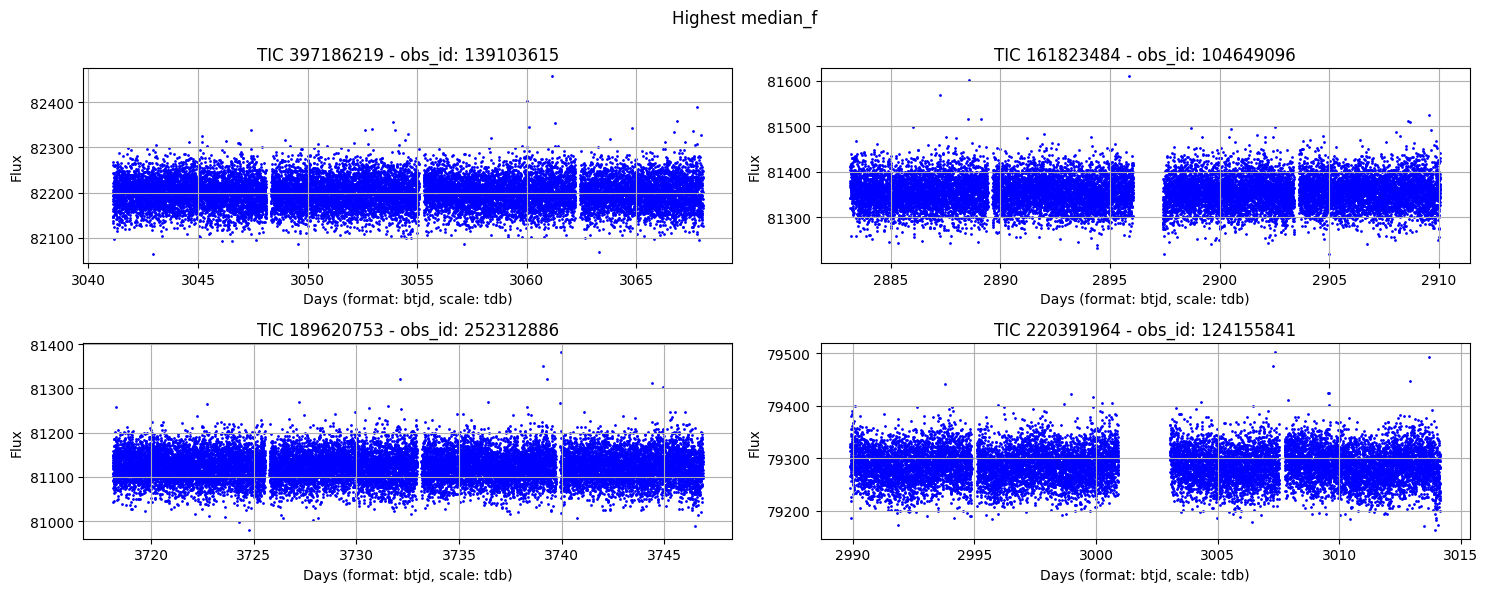

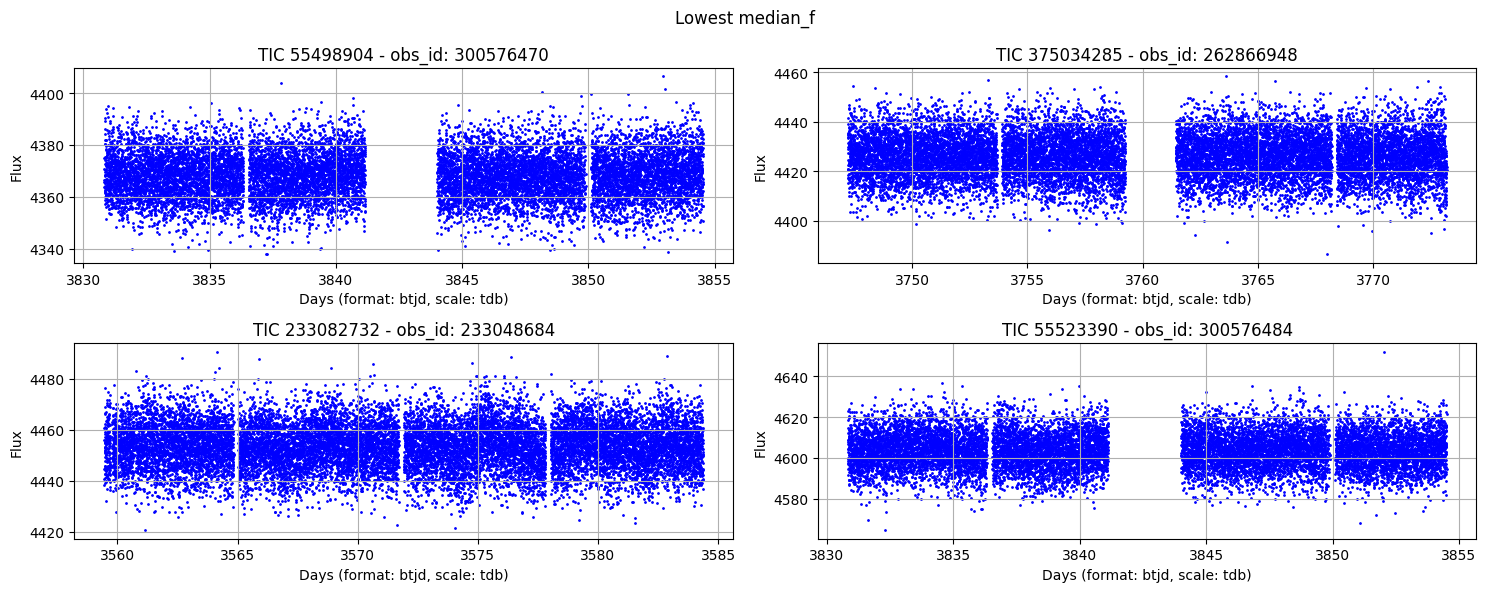

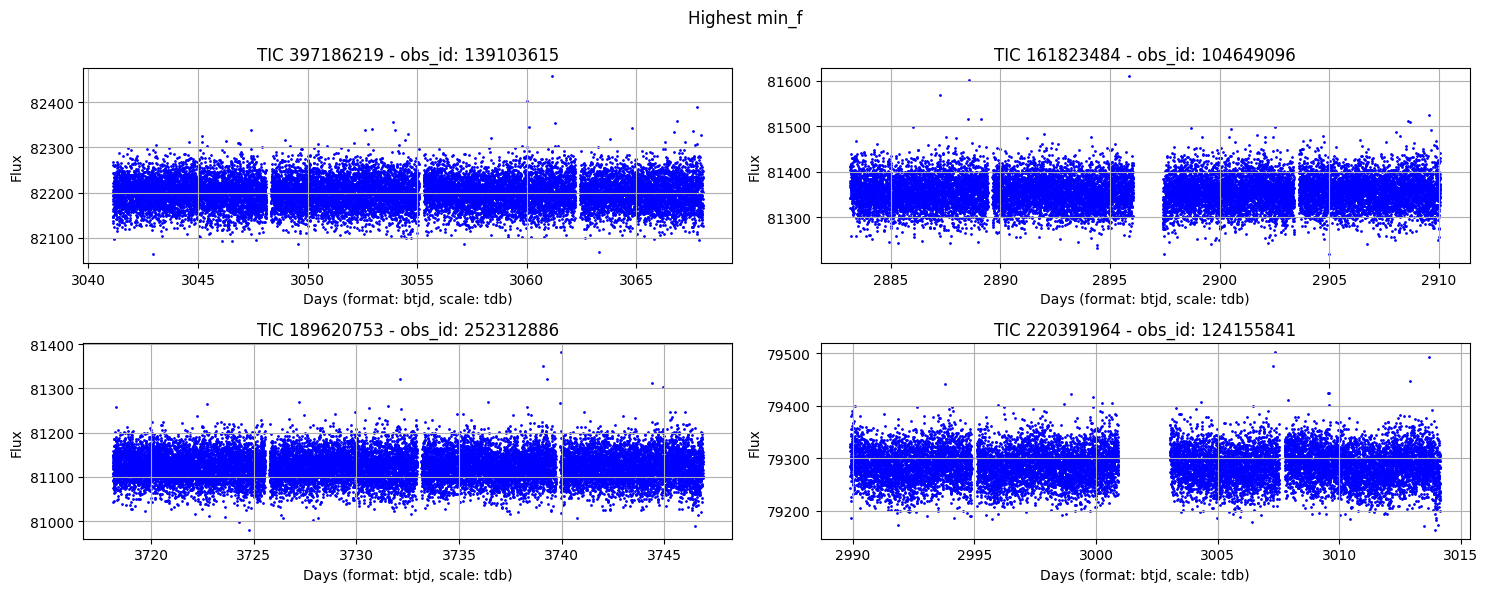

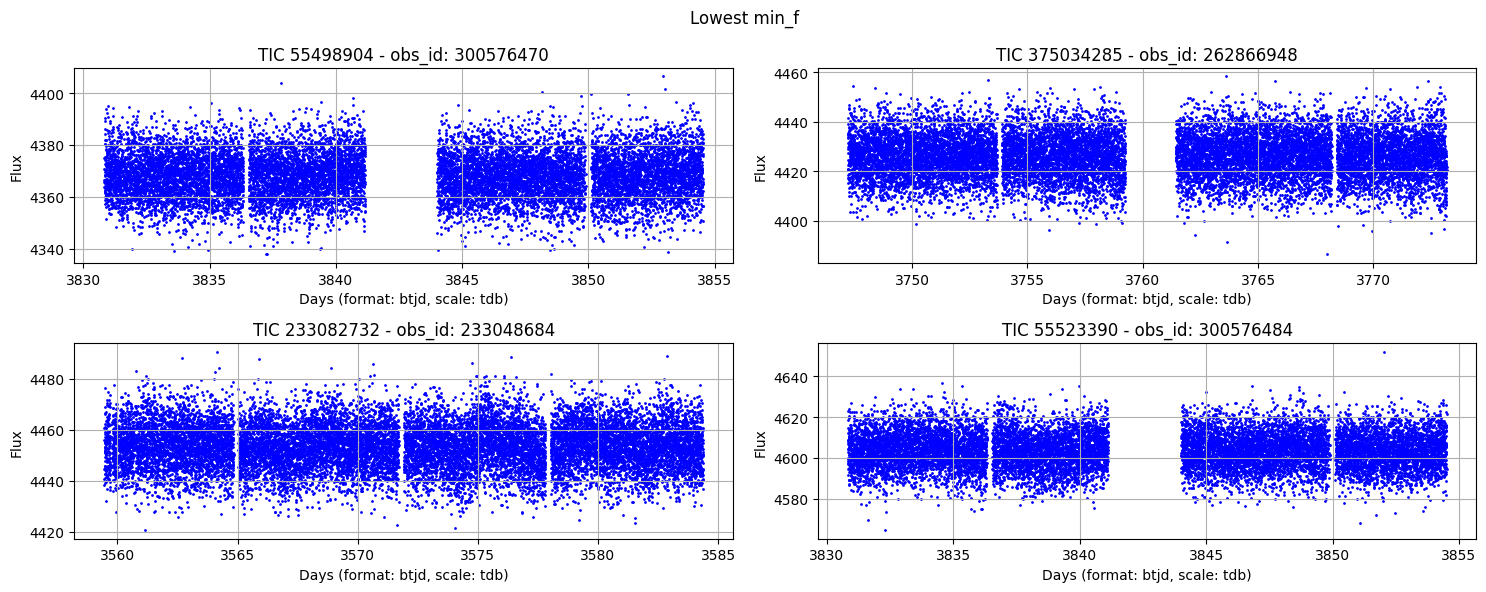

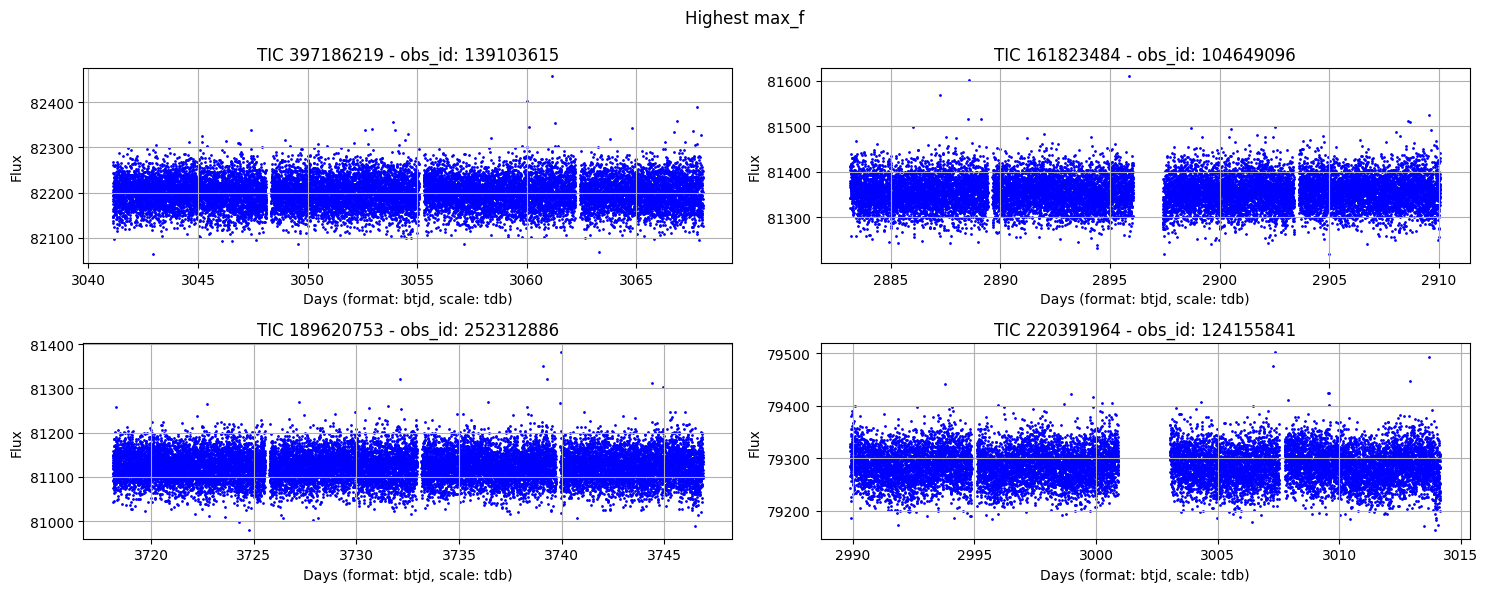

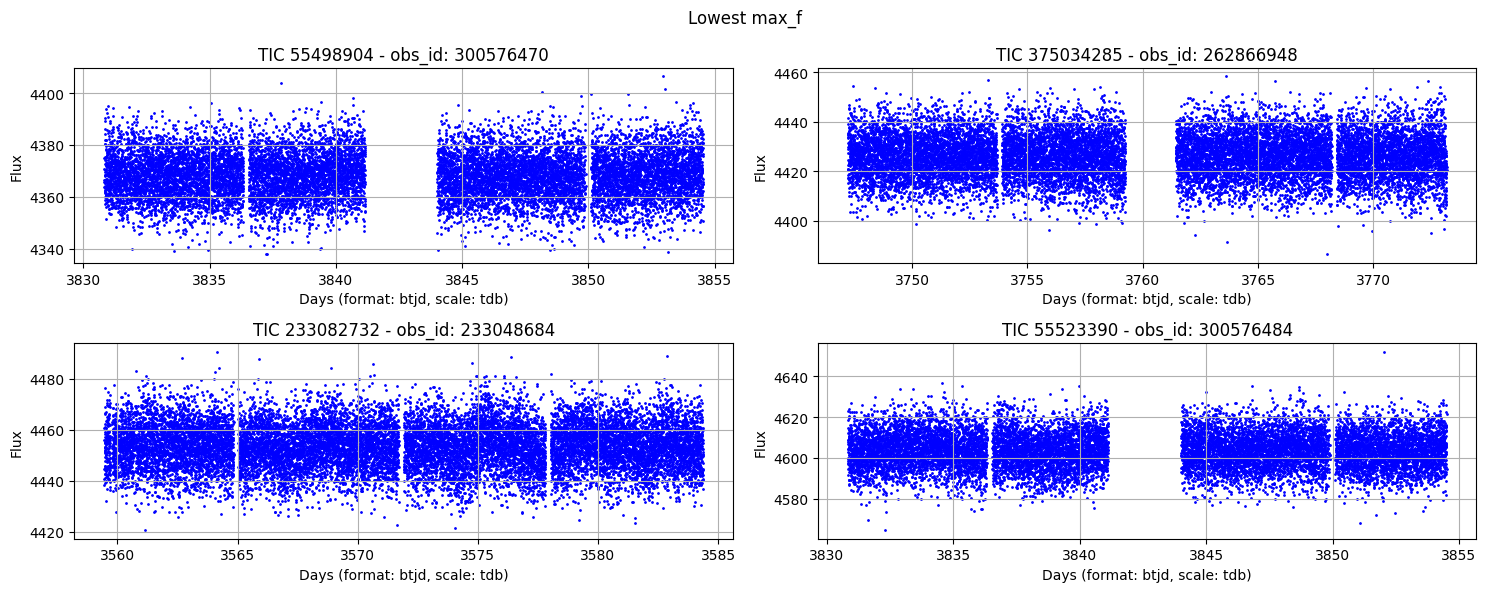

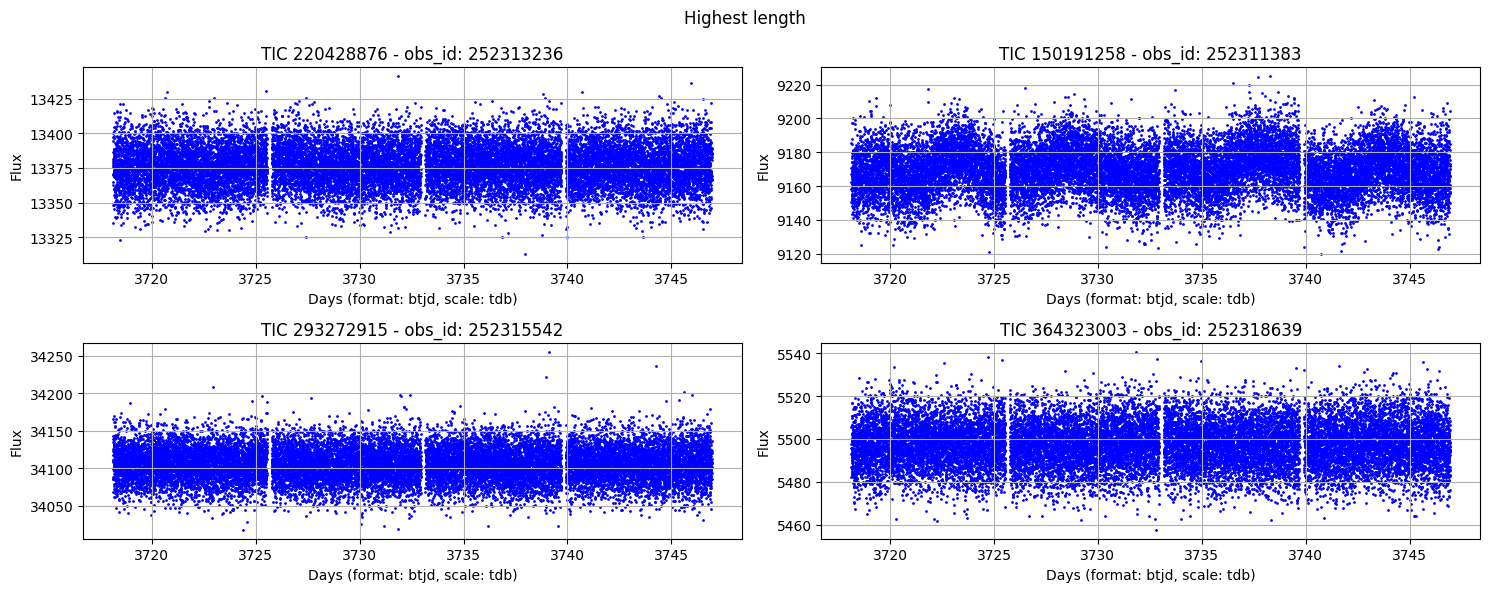

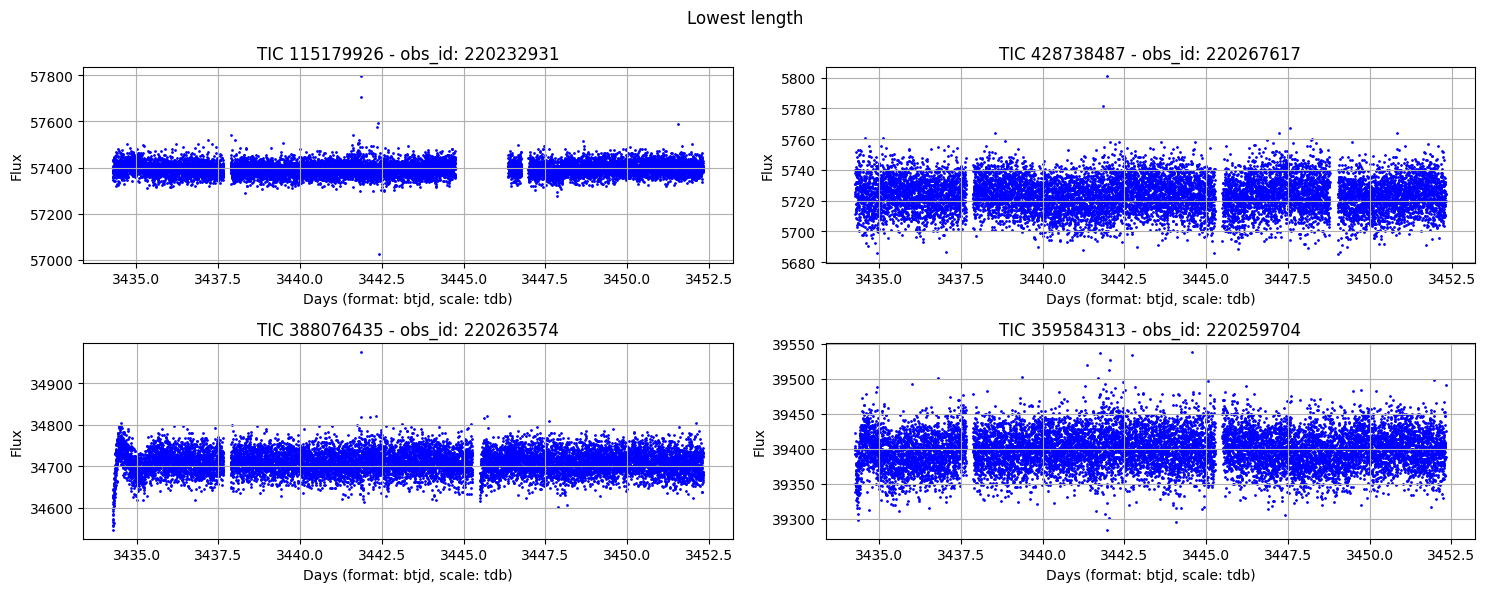

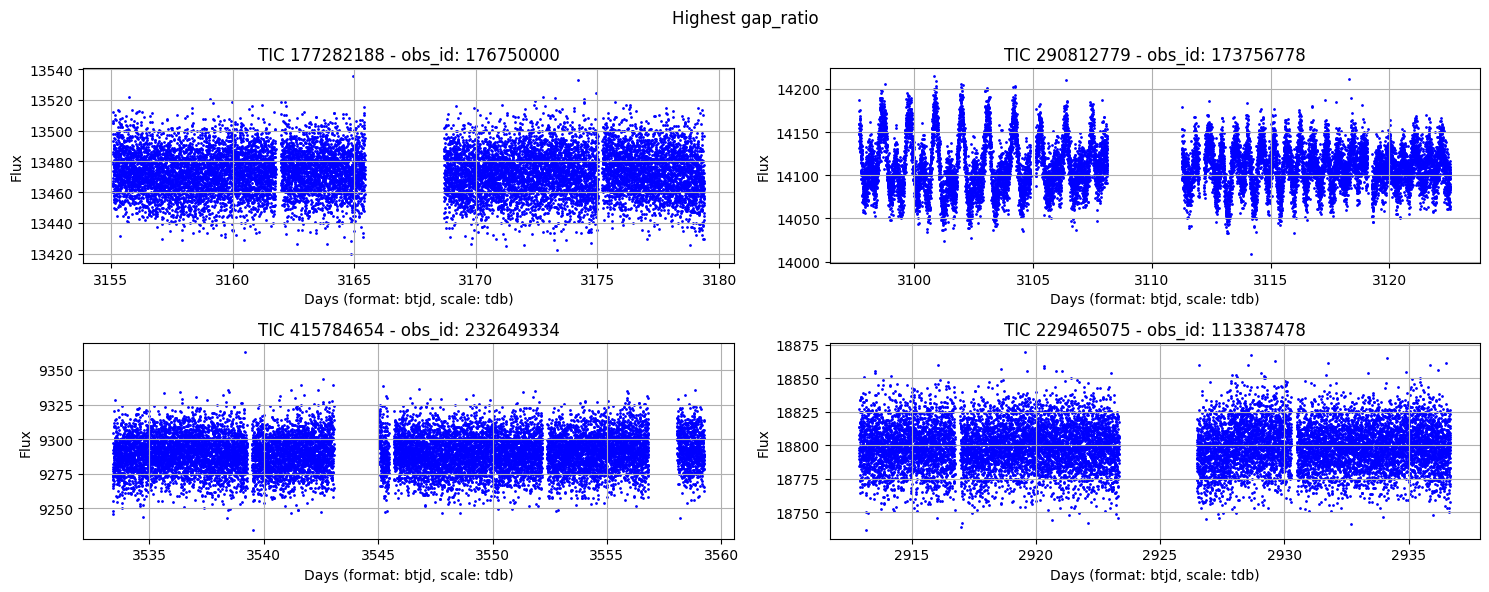

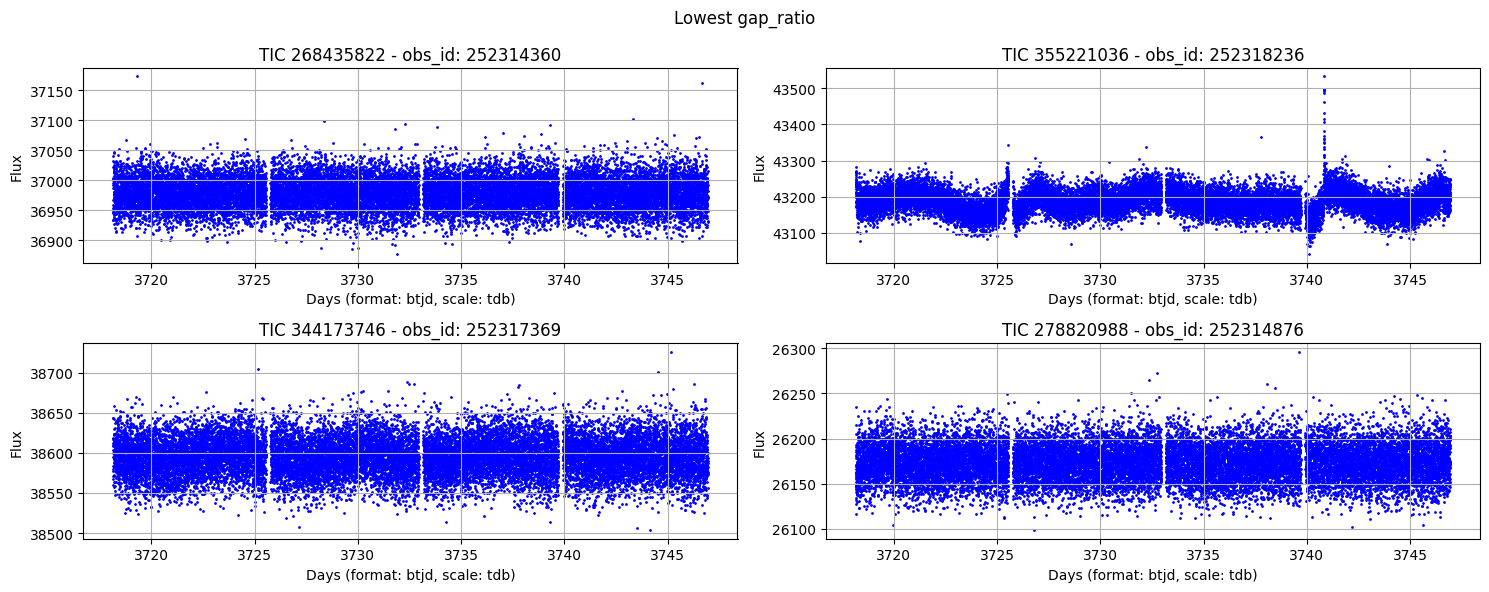

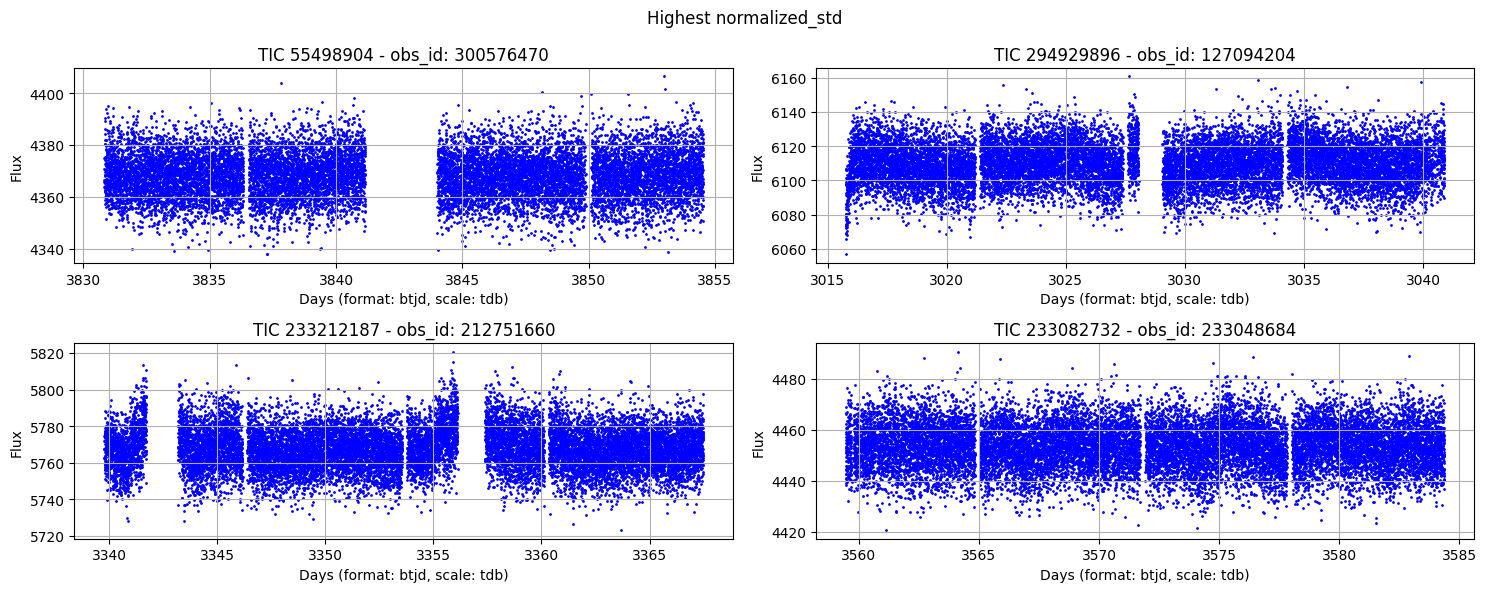

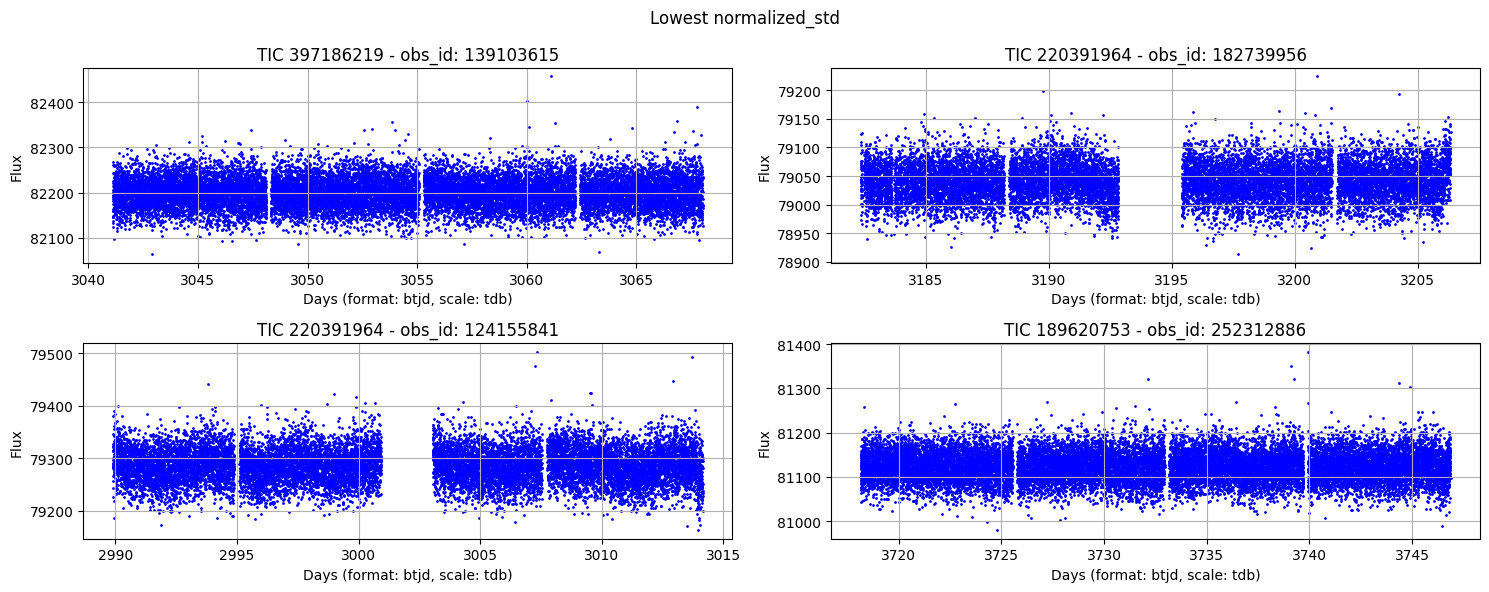

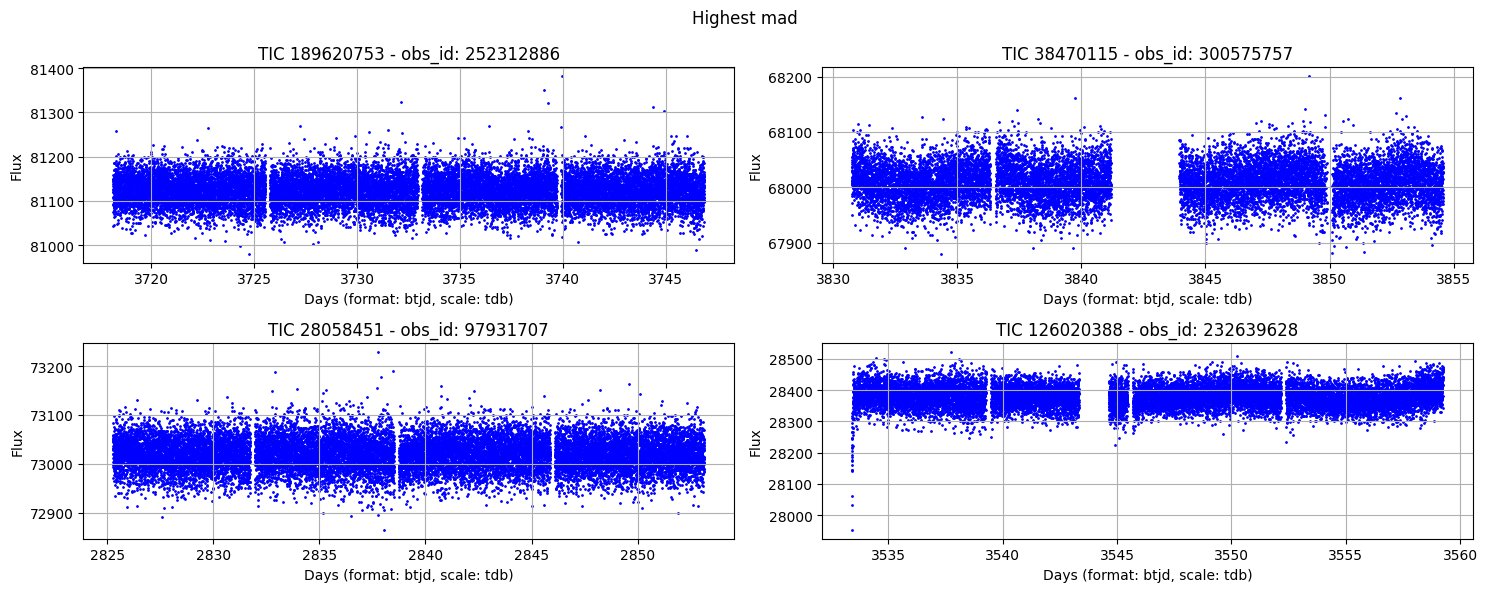

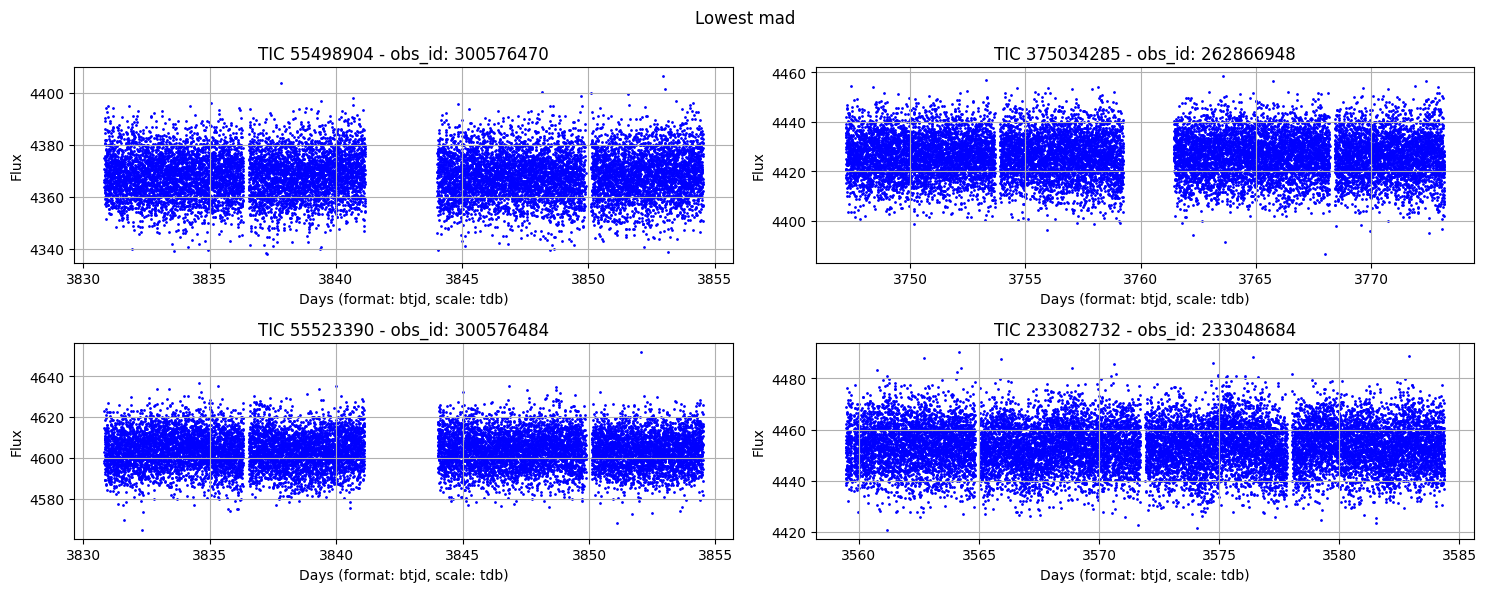

In [10]:
for col in COLUMNS_OF_INTEREST:
    show_high_and_low_parametrer(subset, col)